<a href="https://colab.research.google.com/github/Milikitty/labs/blob/main/assignment.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## PCA and Text Analysis

This assignment involves processing real e-mails, some of which are scams. Some of these scam e-mails have some offensive content. I don't think anything is worse than R-rated, but I just want to warn you that if you start reading the e-mail text, you might read something offensive. If that's a problem, feel free to e-mail me and we can talk about it more or you can skip the assignment.  

### Q1.

Open the `Phishing_Email.parquet` data. It is available at `https://data434.s3.us-east-2.amazonaws.com/Phishing_Email.parquet`, and you can download it directly using Pandas by providing that URL: `df = pd.read_parquet('https://data434.s3.us-east-2.amazonaws.com/Phishing_Email.parquet')`.

We just want to look at the first step of cleaning text data, so you can get an idea of how it works. The `Email Text` variable contains the actual text of the email and the `Email Type` takes the value `Phishing Email` or `Safe Email`. We want to predict which emails are phishing emails from their contents.

Use the `str.split()` method to break the `Phishing Email` values into **tokens**: The individual words or symbols that create text data like emails. Natural Language Processing is primarily about analyzing the frequency and co-occurrence of tokens. Print the results of your split and examine it.

In words, how would you clean the tokens and use them to predict whether the email is a phishing scam or not? A short summary of the kinds of tasks you would do and how you would run a predictive algorithm is fine.

In [2]:
import numpy as np
import pandas as pd
import pickle
from collections import Counter
from multiprocessing.pool import Pool
from sklearn.decomposition import PCA
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score
import seaborn as sns
import matplotlib.pyplot as plt

In [3]:
df = pd.read_parquet('https://data434.s3.us-east-2.amazonaws.com/Phishing_Email.parquet')
tokens = df['Email Text'].str.split()
tokens.head()

,Email Text
0,"[re, :, 6, ., 1100, ,, disc, :, uniformitarian..."
1,"[the, other, side, of, *, galicismos, *, *, ga..."
2,"[re, :, equistar, deal, tickets, are, you, sti..."
3,"[Hello, I, am, your, hot, lil, horny, toy., I,..."
4,"[software, at, incredibly, low, prices, (, 86,..."


Remove stop words to correspond to punctuation and really common words like "and" and "the", and numbers. Then one-hot-encoded the tokens for each e-mail as features/covariates/predictors. Ran algorithms that used the presence of tokens to predict scams

### Q2.

I aggregated all the emails into a single vector, and removed the punctuation and very common words (e.g. "the"). Run the below code chunk to open it, and use the Counter class to look at the most common words:

,count
count,48691.000000
mean,5.687889
std,27.717476
min,1.000000
25%,1.000000
50%,1.000000
75%,2.000000
max,1365.000000


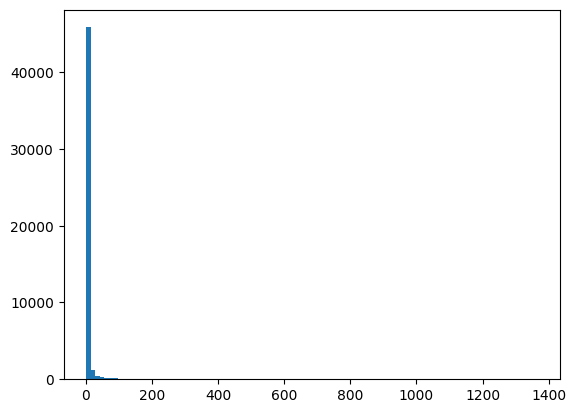

In [5]:
with open('all_tokens.pickle', 'rb') as file:
    all_tokens = pickle.load(file)

from collections import Counter
token_count = Counter(all_tokens)
token_freq = token_count.most_common()

gdf = pd.DataFrame(token_freq, columns=['token', 'count'])
gdf['count'].hist(grid=False,bins=100)

gdf['count'].describe()

appears to have an extremely long tail with most tokens occuring once . But the maximum number of times something appeared was 1,365 times. But this means that a word only appearing once has very predictive value and those like a, and, and the can't be predictive

Plot a histogram of the occurrences of tokens. What do you notice about the frequency of occurrence of different tokens? How does it look?

### Q3.

Load `Phishing_clean.parquet`. This is the text from the e-mails broken into the most common 2,711 tokens and one-hot-encoded as features/covariates. So each row is an e-mail, the `Email Type` takes the value 1 if it's a scam and 0 otherwise, and every other column is a word or symbol that occurs in at least 15 e-mails.

1. Perform an 80/20 train-test split of the data.
2. Run a regression of $y$ on the one-hot-encoded emails. What is the $R^2$ on the test set? On the training set?
3. What words have the largest coefficients in absolute value and most strongly influence predictions?

In [6]:
df = pd.read_parquet('https://data434.s3.us-east-2.amazonaws.com/Phishing_Email.parquet')
df.head()

,index,Unnamed: 0,Email Text,Email Type
0,0,0,"re : 6 . 1100 , disc : uniformitarianism , re ...",Safe Email
1,1,1,the other side of * galicismos * * galicismo *...,Safe Email
2,2,2,re : equistar deal tickets are you still avail...,Safe Email
3,3,3,\nHello I am your hot lil horny toy.\n I am...,Phishing Email
4,4,4,software at incredibly low prices ( 86 % lower...,Phishing Email


In [13]:
df = pd.read_parquet('Phishing_clean.parquet')

y = df['Email Type']
X = df.drop('Email Type',axis=1)

## 1.
X_train, X_test, y_train, y_test = train_test_split(X, y,
                                                    test_size=0.2, random_state=125)

## 2.
lm_0 = LinearRegression(fit_intercept=False).fit(X_train,y_train)
y_hat_test_0 = lm_0.predict(X_test)
y_hat_train_0 = lm_0.predict(X_train)
print('train: ', r2_score(y_hat_train_0,y_train) )
print('test: ', r2_score(y_hat_test_0,y_test) )

train:  0.6210107280960204
test:  -0.00026838432670373


In [16]:
coefficient = lm_0.coef_
tokens = X.columns

coef_df = pd.DataFrame({'token':tokens, 'coefficient':coefficient})
coef_df['Abs_coefficient'] = coef_df['coefficient'].abs()
coef_df.sort_values('Abs_coefficient',ascending=False).head(10)

print("Top words with largest coefficients:")
print(coef_df.sort_values('Abs_coefficient',ascending=False).head(10))

Top words with largest coefficients:
                                                  token   coefficient  \
710                                                1997 -1.415784e+13   
421                                                1995  1.158467e+13   
1133                                                19, -1.025713e+13   
340                                                2005 -9.773947e+12   
1146                                              -0400 -8.062341e+12   
237                                                1999  7.479118e+12   
33                                                 2001  7.316781e+12   
1998                                                7.3 -7.282920e+12   
318                                                 100  7.169511e+12   
1798  url(http://images.lockergnome.com/images/issue... -6.764639e+12   

      Abs_coefficient  
710      1.415784e+13  
421      1.158467e+13  
1133     1.025713e+13  
340      9.773947e+12  
1146     8.062341e+12  
237      7.4791

In [21]:
top = pd.DataFrame({'variable': lm_0.feature_names_in_, 'value':lm_0.coef_})
top['abs'] = np.abs(top['value'])
top.sort_values('abs',ascending=False)

,variable,value,abs
710,1997,-1.415784e+13,1.415784e+13
421,1995,1.158467e+13,1.158467e+13
1133,"19,",-1.025713e+13,1.025713e+13
340,2005,-9.773947e+12,9.773947e+12
1146,-0400,-8.062341e+12,8.062341e+12
...,...,...,...
1399,union,2.822876e-04,2.822876e-04
565,east,-2.746582e-04,2.746582e-04
2268,ravages,-1.068115e-04,1.068115e-04
457,due,-6.484985e-05,6.484985e-05


well. It seems that the model is being overfitted. Unfortunately, this is probabably an artifact of how things work since... there's probably 2711 words that are in some ways correlated with each other. Even the R2 value being only about 0.62 means performance is good but not necessarily that much better than chance.

The top entries are numbers which makes it a lot harder to figure out what's important

### Q4.

Take the matrix of one-hot-encoded tokens (the data, less the outcome variable, `Email Type`) and perform a principal components analysis decomposition with two components. Plot the first two principal components in a scatter plot, and hue the points by whether they are a phishing scam or not. Do you notice any patterns?

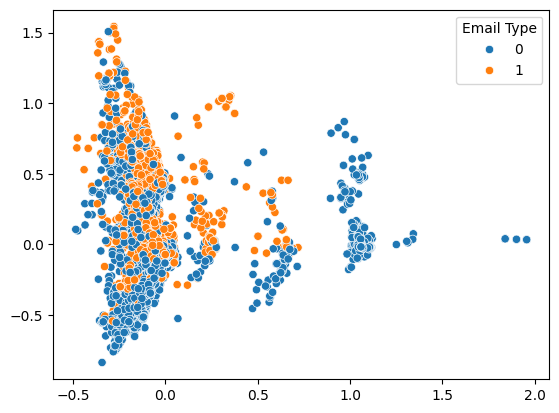

In [25]:
pca = PCA(n_components=2).fit(X_train)
Z_train = pca.transform(X_train)
Z_test = pca.transform(X_test)
sns.scatterplot(x=Z_train[:,0], y=Z_train[:,1], hue=y_train)
plt.show()



Orange is scam. High second components. Try and tease out the blue vs orange

### Q5.

Run a linear regression of $y$ on the first 2,610 principal components of $X$. What is the $R^2$ on the training and test sets? (I used cross validation to determine that 2,610 was approximately optimal, but not all 2,711 components.)

How does this performance compare to the linear regression?

In [26]:
pca = PCA(n_components=2610).fit(X_train)
Z_train = pca.transform(X_train)
Z_test = pca.transform(X_test)

lm_1 = LinearRegression().fit(Z_train,y_train)
y_hat_test_1 = lm_1.predict(Z_test)
y_hat_train_1 = lm_1.predict(Z_train)
print('train: ', r2_score(y_hat_train_1,y_train) )
print('test: ', r2_score(y_hat_test_1,y_test) )

train:  0.692897536096375
test:  0.5873905973217184


In [ ]:
#The performance of this compared to linear regression is much better. The R2 value is much closer to 1 vs 0 in the plain linear regression
#The simple r2 value is much closer to the training value of 0.69

### Q6.

Explain briefly in your own words what the advantage is in using the principal components to run this high-dimensional regression, rather than the original data.

PCA is especially useful when there's a dataset with a large number of highly correlated variables. This is especially true in the case of words that might indicate spam as there's a great deal of potentialy words that may indicate this and there's high colliearity due to the fact it usually isn't one word alone that's an indication of spam but ones that are in a pattern or word order. PCA has the capability to reduce dimensionality and allows for the analysis for the variables that are most strongly correlated
